In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cпециалисты рекомендуют при использовании метода удаления придерживаться следующих правил: удаляйте столбец, если число пропусков в нем более 30-40 %. В остальных случаях лучше удалять записи.

Для удаления строк и столбцов будем использовать метод dropna(), который позволяет удалять пропуски с тонким подходом к настройке. 

Основные параметры метода:

axis — ось, по которой производится удаление (по умолчанию 0 — строки).
how — как производится удаление строк (any — если хотя бы в одном из столбцов есть пропуск, стоит по умолчанию; all — если во всех столбцах есть пропуски). 
thresh — порог удаления. Определяет минимальное число непустых значений в строке/столбце, при котором она/он сохраняется. Например, если мы установим thresh в значение 2, то мы удалим строки, где число пропусков больше чем , где  — число признаков (если ).

In [19]:
sber_data = pd.read_csv('data/sber_data.csv')
#вычислим средний по столбцам результат метода isnull().
#Получим долю пропусков в каждом столбце.
#Умножаем на 100 %, находим столбцы, где доля пропусков больше 0, 
#сортируем по убыванию:
cols_null_percent = sber_data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
#создаем копию исходной таблицы
drop_data = sber_data.copy()
#задаем минимальный порог: вычисляем 70% от числа строк
thresh = drop_data.shape[0]*0.7
#удаляем столбцы, в которых более 30% (100-70) пропусков
drop_data = drop_data.dropna(thresh=thresh, axis=1)
#удаляем записи, в которых есть хотя бы 1 пропуск
drop_data = drop_data.dropna(how='any', axis=0)
#отображаем результирующую долю пропусков
drop_data.isnull().mean()
print(drop_data.shape)

(20888, 60)


Итак, мы удалили один столбец и ⅓ всех записей для того, чтобы избавиться от пропусков. Не слишком ли это много и что с этим можно сделать?

Чтобы дырявая бочка не протекала, вставьте в дырку пробку. С этой мыслью связан другой способ бороться с пропусками — заполнение константами. 

Чаще всего пустые места заполняют средним/медианой/модой для числовых признаков и модальным значением для категориальных признаков

вся сложность заключается в выборе метода заполнения. Важным фактором при выборе метода является распределение признаков с пропусками. Давайте выведем их на экран. 

В pandas это можно сделать с помощью метода hist():

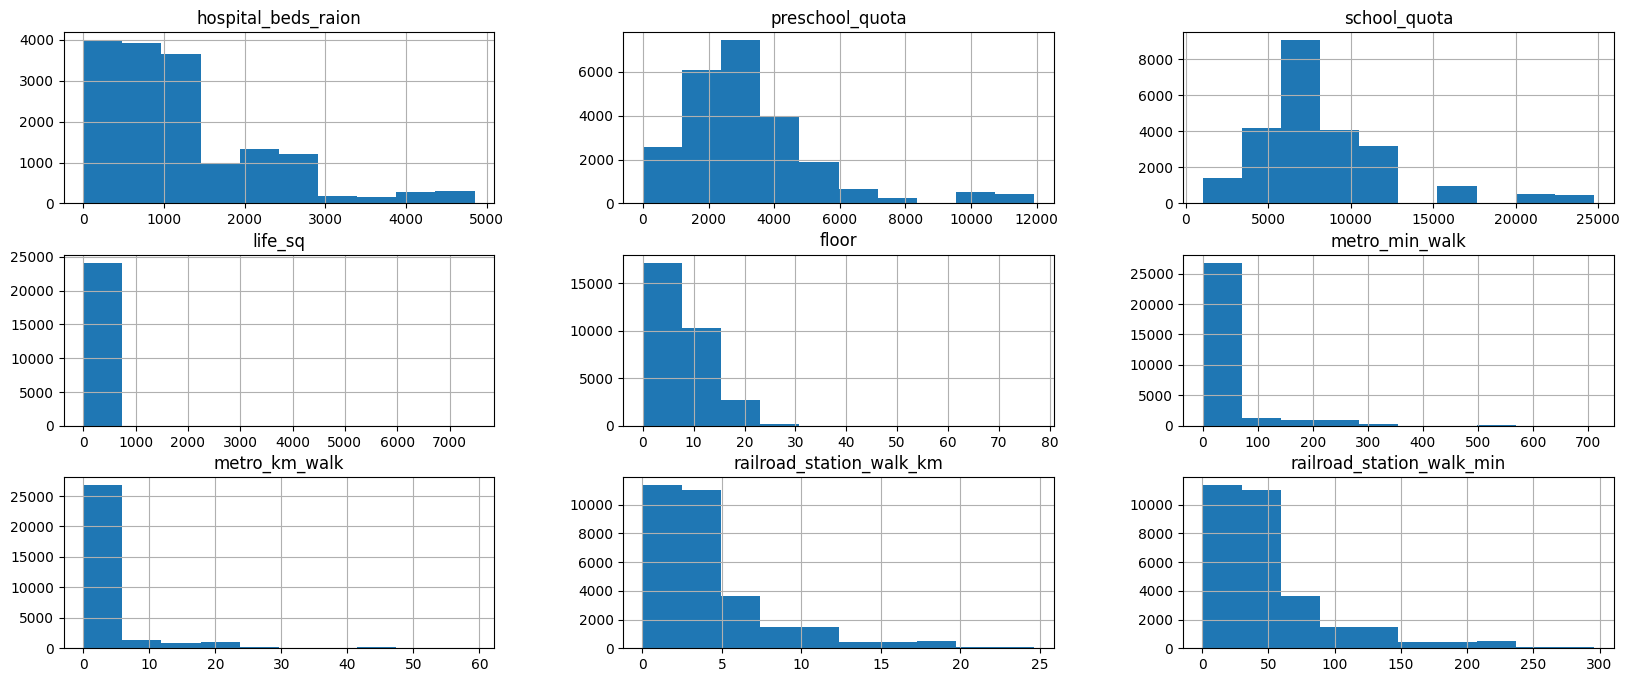

In [20]:
cols = cols_with_null.index
sber_data[cols].hist(figsize=(20, 8));

Заполнение значений осуществляется с помощью метода fillna(). Главный параметр метода — value (значение, на которое происходит заполнение данных в столбце). Если метод вызывается от имени всего DataFrame, то в качестве value можно использовать словарь, где ключи — названия столбцов таблицы, а значения словаря — заполняющие константы. 

Создадим такой словарь, соблюдая рекомендации, приведённые выше, а также копию исходной таблицы. Произведём операцию заполнения с помощью метода fillna() и удостоверимся, что пропусков в данных больше нет:

In [21]:
#создаем копию исходной таблицы
fill_data = sber_data.copy()
#создаем словарь имя столбца: число(признак) на который надо заменить пропуски
values = {
    'life_sq': fill_data['full_sq'],
    'metro_min_walk': fill_data['metro_min_walk'].median(),
    'metro_km_walk': fill_data['metro_km_walk'].median(),
    'railroad_station_walk_km': fill_data['railroad_station_walk_km'].median(),
    'railroad_station_walk_min': fill_data['railroad_station_walk_min'].median(),
    'hospital_beds_raion': fill_data['hospital_beds_raion'].mode()[0],
    'preschool_quota': fill_data['preschool_quota'].mode()[0],
    'school_quota': fill_data['school_quota'].mode()[0],
    'floor': fill_data['floor'].mode()[0]
}
#заполняем пропуски в соответствии с заявленным словарем
fill_data = fill_data.fillna(values)
#выводим результирующую долю пропусков
fill_data.isnull().mean()

id                   0.0
full_sq              0.0
life_sq              0.0
floor                0.0
sub_area             0.0
                    ... 
theater_km           0.0
museum_km            0.0
ecology              0.0
mosque_count_1000    0.0
price_doc            0.0
Length: 61, dtype: float64

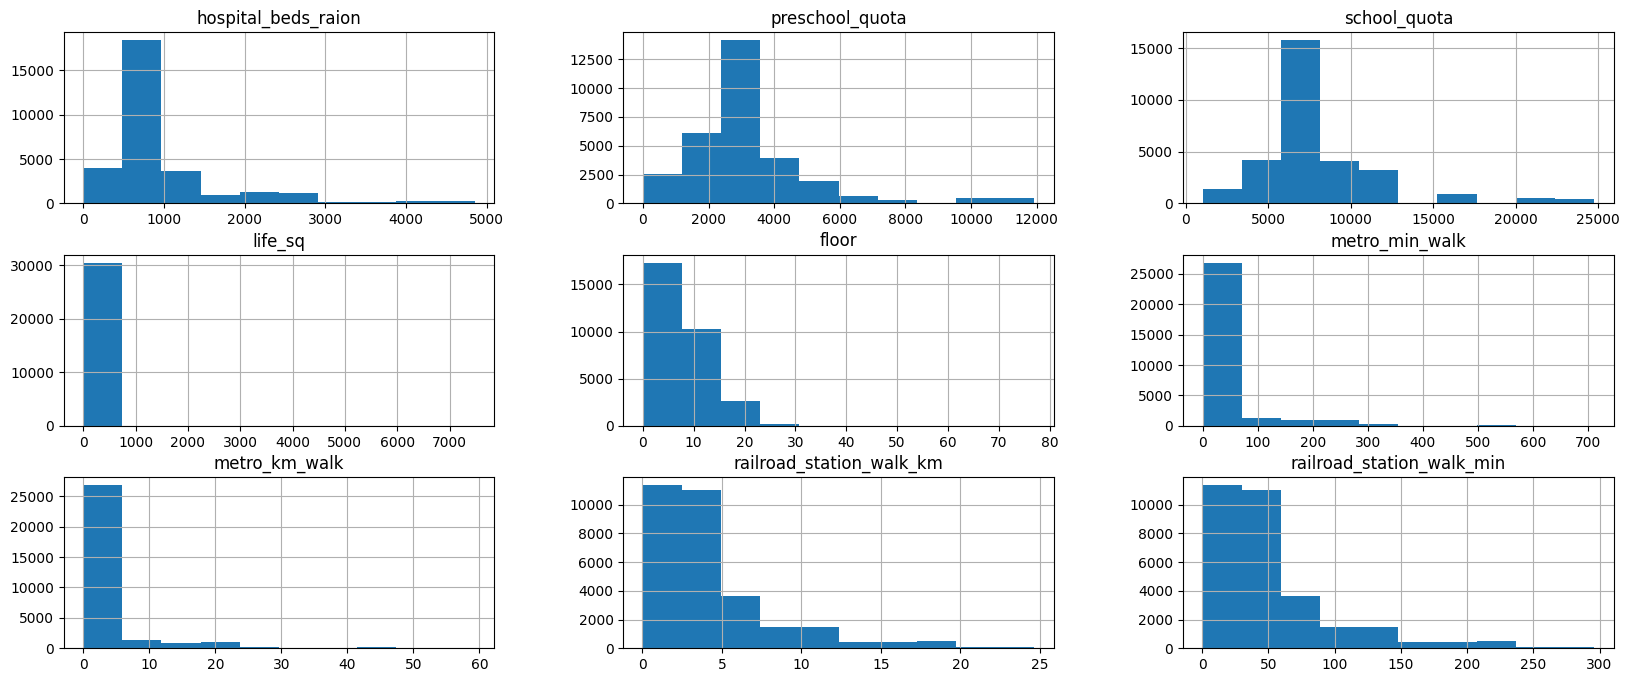

In [23]:
cols = cols_with_null.index
fill_data[cols].hist(figsize=(20, 8));

Недостаток метода заполнения константой состоит в том, что мы можем «нафантазировать» новые данные, которые не учитывают истинного распределения.

если мы используем заполнение пропусков константами, может быть, имеет смысл сказать модели о том, что на этом месте был пропуск? 

Давайте добавим к нашим данным признаки-индикаторы, которые будут сигнализировать о том, что в столбце на определённом месте в таблице был пропуск. Это место в столбце-индикаторе будем помечать как True. 

In [ ]:
#создаем копию исходной таблицы
indicator_data = sber_data.copy()
#в цикле пробегаемся по названиям столбцов с пропусками
for col in cols_with_null.index:
    #создаем новый признак-индикатор как col_was_null
    indicator_data[col + '_was_null'] = indicator_data[col].isnull()
#создаем словарь имя столбца: число(признак) на который надо заменить пропуски   
values = {
    'life_sq': indicator_data['full_sq'],
    'metro_min_walk': indicator_data['metro_min_walk'].median(),
    'metro_km_walk': indicator_data['metro_km_walk'].median(),
    'railroad_station_walk_km': indicator_data['railroad_station_walk_km'].median(),
    'railroad_station_walk_min': indicator_data['railroad_station_walk_min'].median(),
    'hospital_beds_raion': indicator_data['hospital_beds_raion'].mode()[0],
    'preschool_quota': indicator_data['preschool_quota'].mode()[0],
    'school_quota': indicator_data['school_quota'].mode()[0],
    'floor': indicator_data['floor'].mode()[0]
}
#заполняем пропуски в соответствии с заявленным словарем
indicator_data = indicator_data.fillna(values)
#выводим результирующую долю пропусков
indicator_data.isnull().mean()

id                                    0.0
full_sq                               0.0
life_sq                               0.0
floor                                 0.0
sub_area                              0.0
                                     ... 
floor_was_null                        0.0
metro_min_walk_was_null               0.0
metro_km_walk_was_null                0.0
railroad_station_walk_km_was_null     0.0
railroad_station_walk_min_was_null    0.0
Length: 70, dtype: float64

Наверняка вы уже догадались, что необязательно использовать один метод. Вы можете их комбинировать. Например, мы можем:

удалить столбцы, в которых более 30 % пропусков;
удалить записи, в которых более двух пропусков одновременно;
заполнить оставшиеся ячейки константами.
Посмотрим на реализацию такого подхода в коде:

In [ ]:
#создаём копию исходной таблицы
combine_data = sber_data.copy()

#отбрасываем столбцы с числом пропусков более 30% (100-70)
n = combine_data.shape[0] #число строк в таблице
thresh = n*0.7
combine_data = combine_data.dropna(thresh=thresh, axis=1)

#отбрасываем строки с числом пропусков более 2 в строке
m = combine_data.shape[1] #число признаков после удаления столбцов
combine_data = combine_data.dropna(thresh=m-2, axis=0)

#создаём словарь 'имя_столбца': число (признак), на который надо заменить пропуски 
values = {
    'life_sq': combine_data['full_sq'],
    'metro_min_walk': combine_data['metro_min_walk'].median(),
    'metro_km_walk': combine_data['metro_km_walk'].median(),
    'railroad_station_walk_km': combine_data['railroad_station_walk_km'].median(),
    'railroad_station_walk_min': combine_data['railroad_station_walk_min'].median(),
    'preschool_quota': combine_data['preschool_quota'].mode()[0],
    'school_quota': combine_data['school_quota'].mode()[0],
    'floor': combine_data['floor'].mode()[0]
}
#заполняем оставшиеся записи константами в соответствии со словарем values
combine_data = combine_data.fillna(values)
#выводим результирующую долю пропусков
display(combine_data.isnull().mean())

id                                       0.0
full_sq                                  0.0
life_sq                                  0.0
floor                                    0.0
sub_area                                 0.0
preschool_quota                          0.0
preschool_education_centers_raion        0.0
school_quota                             0.0
school_education_centers_raion           0.0
school_education_centers_top_20_raion    0.0
healthcare_centers_raion                 0.0
university_top_20_raion                  0.0
sport_objects_raion                      0.0
additional_education_raion               0.0
culture_objects_top_25_raion             0.0
shopping_centers_raion                   0.0
office_raion                             0.0
oil_chemistry_raion                      0.0
railroad_terminal_raion                  0.0
nuclear_reactor_raion                    0.0
metro_min_avto                           0.0
metro_km_avto                            0.0
metro_min_

In [ ]:
print(combine_data.shape)

(26800, 60)


Ваша задача очистить данную таблицу от пропусков следующим образом:
- Если признак имеет больше 50% пропущенных значений - удалите его
- Для оставшихся данных: если в строке более 2 пропусков - удалите строку
- Для оставшихся данных: числовые признаки заполните средним значением, а категориальные - модой
Результат должен находиться в переменной df

In [ ]:
df = pd.read_csv('./Root/data/test_data.csv')
thresh = df.shape[0]*0.5
df = df.dropna(thresh=thresh, axis=1)
thresh2 = df.shape[1] - 2
df = df.dropna(thresh=thresh2, axis=0)
df = df.fillna({
    'one': df['one'].mean(),
    'two': df['two'].mean(),
    'four': df['four'].mode()[0]})


МЕТОД РУЧНОГО ПОИСКА И ЗДРАВОГО СМЫСЛА

Это самый трудоёмкий метод, основанный на житейской логике, методе пристального взгляда и небольшом количестве статистики. Он предполагает поиск невозможных и нелогичных значений в данных.

Пусть у нас есть признак, по которому мы будем искать выбросы. Давайте рассчитаем его статистические показатели (минимум, максимум, среднее, квантили) и по ним попробуем определить наличие аномалий.

Сделать это можно с помощью уже знакомого вам метода describe(). Рассчитаем статистические показатели для признака жилой площади (life_sq).



In [ ]:
sber_data['life_sq'].describe()

count    24088.000000
mean        34.403271
std         52.285733
min          0.000000
25%         20.000000
50%         30.000000
75%         43.000000
max       7478.000000
Name: life_sq, dtype: float64

Что нам говорит метод describe()? Во-первых, у нас есть квартиры с нулевой жилой площадью. Во-вторых, в то время как 75-й квантиль равен 43, максимум превышает 7 тысяч квадратных метров (целый дворец, а не квартира!). 

Найдём число квартир с нулевой жилой площадью:

In [ ]:
print(sber_data[sber_data['life_sq'] == 0].shape[0])

45


Таких помещений оказывается 45 штук. Что это за зверь?

Это могут быть апартаменты — вид коммерческой недвижимости, которая юридически не является жилой площадью, но законно продаётся по ценам, сопоставимым с квартирными. Оставим их в покое.     

А теперь выведем здания с жилой площадью более 7 000 квадратных метров:

In [ ]:
display(sber_data[sber_data['life_sq'] > 7000])

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
13546,13549,79,7478.0,8.0,Poselenie Voskresenskoe,NaN,0,NaN,0,0,...,5.072389,1.210613,0.826052,1.582378,0.756119,21.472421,14.917332,no data,0,7705000


Вот он, красавец! Выброс налицо: гигантская жилая площадь (life_sq), да ещё почти в 100 раз превышает общую площадь (full_sq).

?
Логичен вопрос: а много ли у нас таких квартир, у которых жилая площадь больше, чем суммарная?

Давайте проверим это с помощью фильтрации:

In [ ]:
outliers = sber_data[sber_data['life_sq'] > sber_data['full_sq']]
print(outliers.shape[0])

37


Таких квартир оказывается 37 штук. Подобные наблюдения уже не поддаются здравому смыслу — они являются ошибочными, и от них стоит избавиться. Для этого можно воспользоваться методом drop() и удалить записи по их индексам:

In [ ]:
cleaned = sber_data.drop(outliers.index, axis=0)
print(f'Результирующее число записей: {cleaned.shape[0]}')

Результирующее число записей: 30434


Ещё пример: давайте посмотрим на признак числа этажей (floor).

In [ ]:
display(sber_data['floor'].describe())

count    30304.000000
mean         7.670803
std          5.319989
min          0.000000
25%          3.000000
50%          6.500000
75%         11.000000
max         77.000000
Name: floor, dtype: float64

Снова видим подозрительную максимальную отметку в 77 этажей. Проверим все квартиры, которые находятся выше 50 этажей:

In [24]:
display(sber_data[sber_data['floor']> 50])

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,mosque_count_1000,price_doc
23584,23587,57,33.0,77.0,Lomonosovskoe,3091.0,5,8359.0,7,1,...,0.310557,0.731683,0.489763,0.86354,0.863266,2.920671,2.757058,satisfactory,0,13700000


Вы наверняка обратили внимание на сложность ручного поиска. Мы заранее знали про апартаменты и о том, что не бывает квартир с жилой площадью, которая превышает общую. Кроме того, мы «нагуглили» информацию о московских высотках. Однако бывают данные, где необходимо углубиться в предметную область, чтобы понять, что наблюдения являются «сверхъестественными».

МЕТОД МЕЖКВАРТИЛЬНОГО РАЗМАХА (МЕТОД ТЬЮКИ)

Отличным помощником в поиске потенциальных выбросов является визуализация. Если признак является числовым, то можно построить гистограмму или коробчатую диаграмму, чтобы найти аномалии.

На гистограмме мы можем увидеть потенциальные выбросы как низкие далеко отстоящие от основной группы столбцов «пеньки», а на коробчатой диаграмме — точки за пределами усов.

✍️ Построим гистограмму и коробчатую диаграмму для признака полной площади (full_sq):

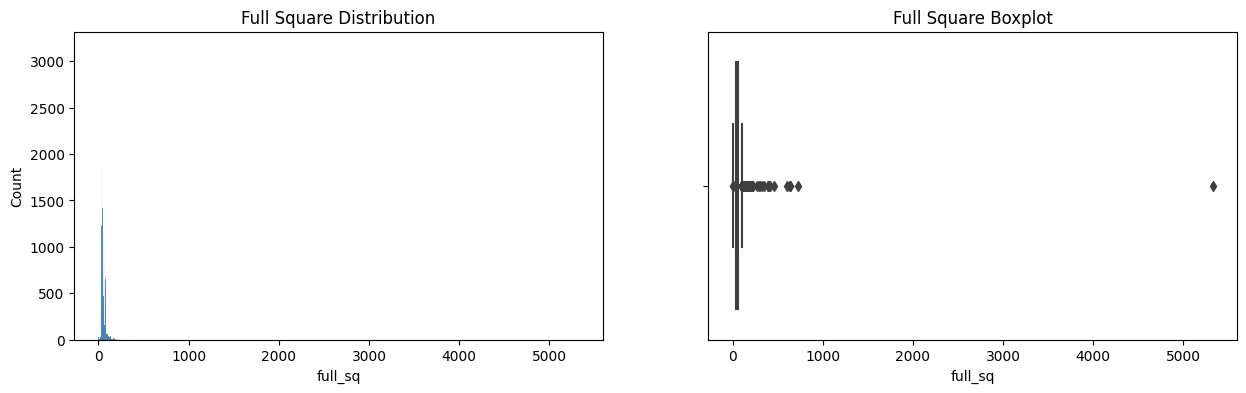

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=sber_data, x='full_sq', ax=axes[0]);
histplot.set_title('Full Square Distribution');
boxplot = sns.boxplot(data=sber_data, x='full_sq', ax=axes[1]);
boxplot.set_title('Full Square Boxplot');

Основная масса квартир имеет общую площадь менее 250 квадратных метров, и лишь несколько невзрачных наблюдений выбиваются из этого интервала. Максимальная площадь, судя по гистограмме, превышает 5 000 квадратных метров.


Визуализация помогает определить наличие выбросов. Для того чтобы их найти, можно воспользоваться статистическими подходами. 

Одним из таких подходов является метод межквартильного размаха (его еще называют методом Тьюки), который используется для построения коробчатой диаграммы.

Алгоритм метода:

→ вычислить 25-ый и 75-ый квантили (первый и третий квартили) — и  для признака, который мы исследуем;

→ вычислить межквартильное расстояние: ;

→ вычислить верхнюю и нижнюю границы Тьюки: 

→ найти наблюдения, которые выходят за пределы границ.

В соответствии с этим алгоритмом напишем функцию outliers_iqr(), которая вам может ещё не раз пригодиться в реальных задачах. Эта функция принимает на вход DataFrame и признак, по которому ищутся выбросы, а затем возвращает потенциальные выбросы, найденные с помощью метода Тьюки, и очищенный от них датасет.

Квантили вычисляются с помощью метода quantile(). Потенциальные выбросы определяются при помощи фильтрации данных по условию выхода за пределы верхней или нижней границы.

In [26]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

Применим эту функцию к таблице sber_data и признаку full_sq, а также выведем размерности результатов:

In [27]:
outliers, cleaned = outliers_iqr(sber_data, 'full_sq')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 963
Результирующее число записей: 29508


Согласно классическому методу Тьюки, под выбросы у нас попали 963 записи в таблице. Давайте построим гистограмму и коробчатую диаграмму на новых данных cleaned_sber_data:

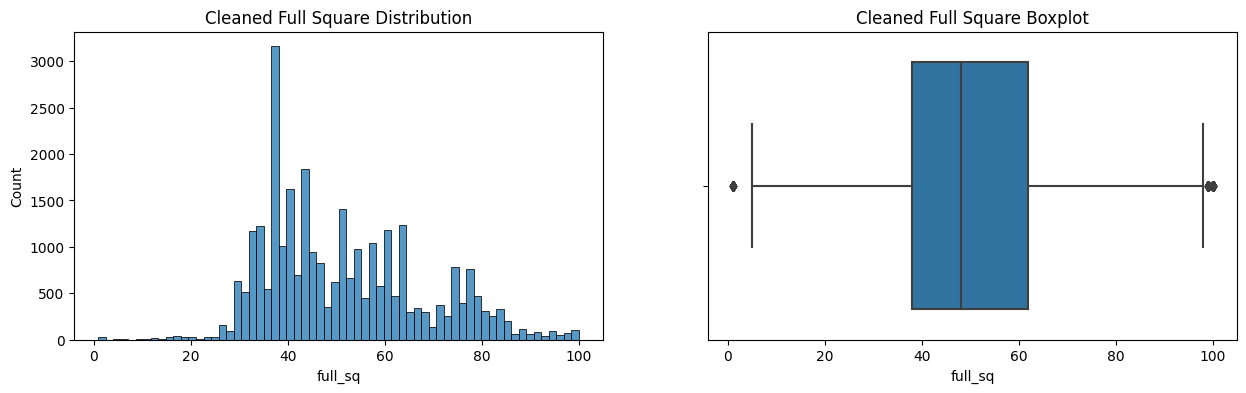

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='full_sq', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='full_sq', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

На первый взгляд — стерильно. Однако если присмотреться, то коробчатая диаграмма всё ещё продолжает говорить, что в данных есть одиночные выбросы с обеих сторон от границ. К тому же у нас сильно урезался диапазон жилой площади — максимальная площадь составляет около 100 кв. м. 

?
Как же так, неужели метод не работает?

Причина кроется в том, что после удаления выбросов квартили рассчитываются заново по новым данным, и так оказалось, что из-за свойств распределения были снова найдены точки, которые считаются выбросами.

У нас же распределение (даже после отсечения выбросов) отличается от заявленных критериев. Оно несимметрично: правый хвост изначального распределения гораздо длиннее левого (для Москвы вполне естественны квартиры с площадью свыше 100 квадратных метров) и вовсе не колоколообразно. Попросту говоря, выбор метода поиска не оправдал себя.

Но не стоит расстраиваться! Никто не говорил, что вы должны должны ограничиваться только 1.5 межквартильных размахов. Вы можете сами подбирать число размахов влево и/или вправо и таким образом отбирать выбросы, учитывая особенности ваших данных. 

Давайте немного модифицируем функцию outliers_iqr(). Добавьте в неё параметры left и right, которые задают число IQR влево и вправо от границ ящика (пусть по умолчанию они равны 1.5). Функция, как и раньше, должна возвращать потенциальные выбросы и очищенный DataFrame.

In [30]:
def outliers_iqr_mod(data, feature, left=1, right=6):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x> upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

Давайте ослабим границы метода Тьюки справа и усилим их влево. Примените модифицированную функцию outliers_iqr_mod() к признаку full_sq из таблицы sber_data данным с параметрами left=1 и right=6. Результаты работы поместите в переменные outliers и cleaned. Чему равно результирующее число выбросов в данных?

In [31]:
outliers, cleaned = outliers_iqr_mod(sber_data, 'full_sq')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 59
Результирующее число записей: 30403


Если мы построим гистограмму и коробчатую диаграмму на полученных данных, то увидим вот такую картинку:

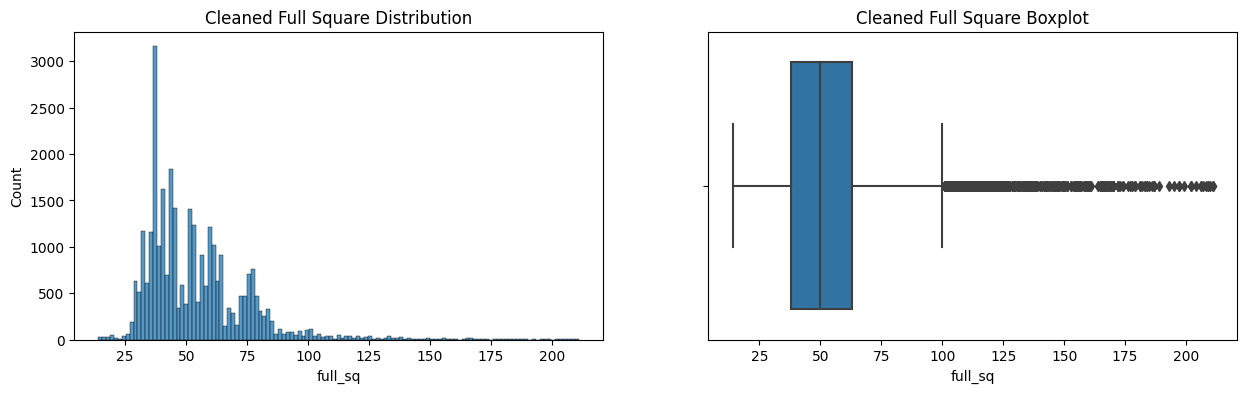

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='full_sq', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='full_sq', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

Построим две гистограммы признака расстояния до МКАД (mkad_km): первая — в обычном масштабе, а вторая — в логарифмическом. Логарифмировать будем с помощью функции log() из библиотеки numpy (натуральный логарифм — логарифм по основанию числа e). Признак имеет среди своих значений 0. Из математики известно, что логарифма от 0 не существует, поэтому мы прибавляем к нашему признаку 1, чтобы не логарифмировать нули и не получать предупреждения.



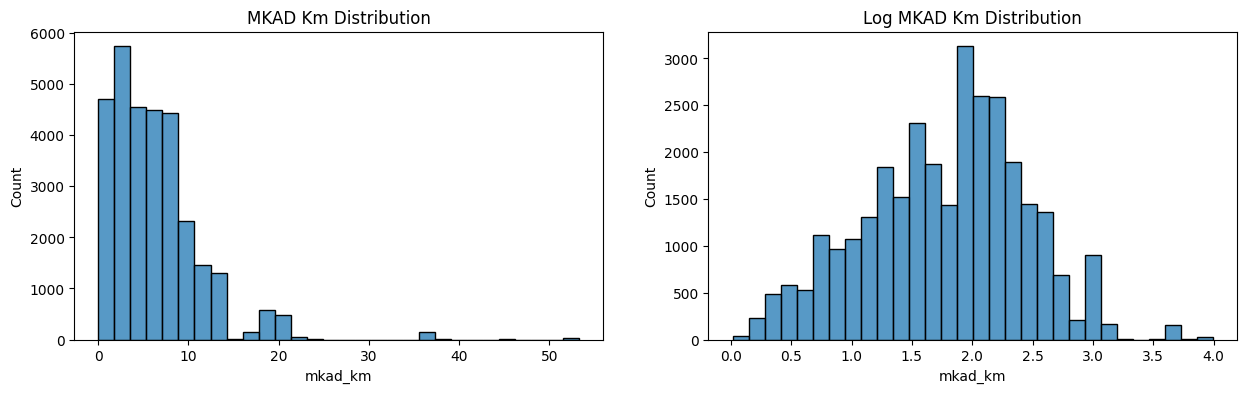

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

#гистограмма исходного признака
histplot = sns.histplot(sber_data['mkad_km'], bins=30, ax=axes[0])
histplot.set_title('MKAD Km Distribution');

#гистограмма в логарифмическом масштабе
log_mkad_km= np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km , bins=30, ax=axes[1])
histplot.set_title('Log MKAD Km Distribution');

In [35]:

print(log_mkad_km.skew())

-0.14263612203024953


Давайте реализуем алгоритм метода z-отклонения. Описание алгоритма метода:

→ вычислить математическое ожидание  (среднее) и стандартное отклонение  признака ;

→ вычислить нижнюю и верхнюю границу интервала как:

→ найти наблюдения, которые выходят за пределы границ.

✍️ Напишем функцию outliers_z_score(), которая реализует этот алгоритм. 

На вход она принимает DataFrame и признак, по которому ищутся выбросы. В дополнение добавим в функцию возможность работы в логарифмическом масштабе: для этого введём аргумент log_scale. Если он равен True, то будем логарифмировать рассматриваемый признак, иначе — оставляем его в исходном виде.

Как и раньше, функция будет возвращать выбросы и очищенные от них данные:

In [36]:
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

Применим эту функцию к таблице sber_data и признаку mkad_km, а также выведем размерности результатов:

In [37]:
outliers, cleaned = outliers_z_score(sber_data, 'mkad_km', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 33
Результирующее число записей: 30438


Итак, метод z-отклонения нашел нам 33 потенциальных выброса по признаку расстояния до МКАД. Давайте узнаем, в каких районах (sub_area) представлены эти квартиры:

In [38]:
print(outliers['sub_area'].unique())

['Poselenie Rogovskoe' 'Poselenie Kievskij']


Наши потенциальные выбросы — это квартиры из поселений «Роговское» и «Киевский». Снова обращаемся к силе интернета и «пробиваем» наших подозреваемых. Эти поселения — самые удалённые районы Московской области; первое из них — это и вовсе граница с Калужской областью. 

?
И тут возникает закономерный вопрос: а стоит ли считать такие наблюдения за выбросы? 

Вопрос в действительности не имеет определенного ответа: с одной стороны, метод прямо-таки говорит нам об этом, а с другой — эти наблюдения имеют право на существование, ведь они являются частью Московской области.

Возможно, мы не учли того факта, что наш логарифм распределения всё-таки не идеально нормален и в нём присутствует некоторая асимметрия. Возможно, стоит дать некоторое «послабление» на границы интервалов? Давайте отдельно построим гистограмму прологарифмированного распределения, а также отобразим на гистограмме вертикальные линии, соответствующие среднему (центру интервала в методе трёх сигм) и границы интервала . Вертикальные линии можно построить с помощью метода axvline(). Для среднего линия будет обычной, а для границ интервала — пунктирной (параметр ls ='--'):

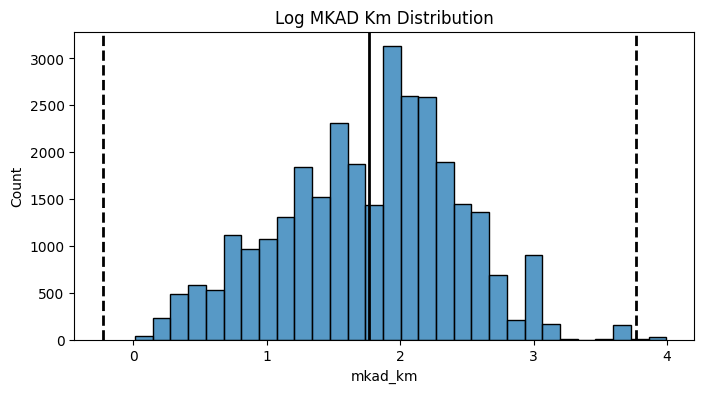

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_mkad_km = np.log(sber_data['mkad_km'] + 1)
histplot = sns.histplot(log_mkad_km, bins=30, ax=ax)
histplot.axvline(log_mkad_km.mean(), color='k', lw=2)
histplot.axvline(log_mkad_km.mean()+ 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.axvline(log_mkad_km.mean()- 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.set_title('Log MKAD Km Distribution');

Итак, что мы графически построили интервал метода трёх сигм поверх нашего распределения. Он показывает, какие наблюдения мы берем в интервал, а какие считаем выбросами. Легко заметить, среднее значение (жирная вертикальная линия) находится левее моды, это свойство распределений с левосторонней асимметрией. Также видны наблюдения, которые мы не захватили своим интервалом (небольшой пенек правее верхней границы) — это и есть наши квартиры из из поселений "Роговское" и "Киевский". Очевидно, что если немного (меньше чем на одну сигму) "сдвинуть" верхнюю границу вправо, мы захватим эти наблюдения. Давайте сделаем это?!

Давайте расширим правило трёх сигм, чтобы иметь возможность особенности данных. Добавьте в функцию outliers_z_score() параметры left и right, которые будут задавать число сигм (стандартных отклонений) влево и вправо соответственно, определяющее границы метода z-отклонения. По умолчанию оба параметры равны 3. Результирующую функцию назовите outliers_z_score_mod().

In [53]:
def outliers_z_score_mod(data, feature, left=3.7, right=3.7, log_scale=True):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [54]:
outliers, cleaned = outliers_z_score_mod(sber_data, 'price_doc', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 52
Результирующее число записей: 30419


Постройте гистограмму для признака price_doc в логарифмическом масштабе. А также, добавьте на график линии, отображающие среднее и границы интервала для метода трех сигм. Выберите верные утверждения:

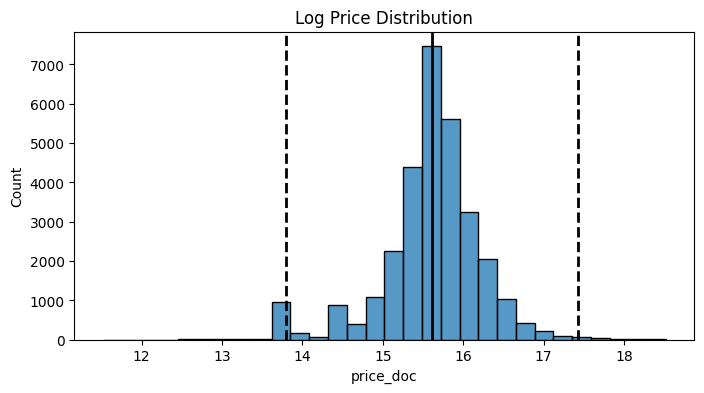

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_price = np.log(sber_data['price_doc'])
histplot = sns.histplot(log_price, bins=30, ax=ax)
histplot.set_title('Log Price Distribution');
histplot.axvline(log_price.mean(), color='k', lw=2)
histplot.axvline(log_price.mean()+ 3 * log_price.std(), color='k', ls='--', lw=2)
histplot.axvline(log_price.mean()- 3 * log_price.std(), color='k', ls='--', lw=2);

Добавьте фишку с логарифмированием в свою функцию outliers_iqr_mod(). Добавьте в неё параметр log_scale. Если он выставлен в True, то производится логарифмирование признака. Примените полученную функцию к признаку price_doc. Число межквартильных размахов в обе стороны обозначьте как 3. Чему равно число выбросов, полученных таким методом?

In [55]:
def outliers_iqr_mod(data, feature, left=1.5, right=1.5, log_scale=False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x= data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned
outliers, cleaned = outliers_iqr_mod(sber_data, 'price_doc', left=3, right=3, log_scale=True)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')

Число выбросов по методу Тьюки: 92


ОБНАРУЖЕНИЕ И ЛИКВИДАЦИЯ ДУБЛИКАТОВ

Способ обнаружения дубликатов зависит от того, что именно вы считаете дубликатом. Например, за дубликаты можно посчитать записи, у которых совпадают все признаки или их часть. Если в таблице есть столбец с уникальным идентификатором (id), вы можете попробовать поискать дубликаты по нему: одинаковые записи могут иметь одинаковый id.

✍️ Проверим, есть у нас такие записи: для этого сравним число уникальных значений в столбце id с числом строк. Число уникальных значений вычислим с помощью метода nunique():

In [56]:
sber_data['id'].nunique() == sber_data.shape[0]

True

Вроде бы всё в порядке: каждой записи в таблице соответствует свой уникальный идентификатор. Но это ещё не означает, что в таблице нет дубликатов!

Столбец с id задаёт каждой строке свой уникальный номер, поэтому сама по себе каждая строка является уникальной. Однако содержимое других столбцов может повторяться.

Чтобы отследить дубликаты, можно воспользоваться методом duplicated(), который возвращает булеву маску для фильтрации. Для записей, у которых совпадают признаки, переданные методу, он возвращает True, для остальных — False.

У метода есть параметр subset — список признаков, по которым производится поиск дубликатов. По умолчанию используются все столбцы в DataFrame и ищутся полные дубликаты.

✍️ Найдём число полных дубликатов таблице sber_data. Предварительно создадим список столбцов dupl_columns, по которым будем искать совпадения (все столбцы, не включая id). 

Создадим маску дубликатов с помощью метода duplicated() и произведём фильтрацию. Результат заносим в переменную sber_duplicates. Выведем число строк в результирующем DataFrame:

In [57]:
dupl_columns = list(sber_data.columns)
dupl_columns.remove('id')

mask = sber_data.duplicated(subset=dupl_columns)
sber_duplicates = sber_data[mask]
print(f'Число найденных дубликатов: {sber_duplicates.shape[0]}')

Число найденных дубликатов: 562


Теперь нам необходимо от них избавиться. Для этого легче всего воспользоваться методом drop_duplicates(), который удаляет повторяющиеся записи из таблицы. 

✍️ Создадим новую таблицу sber_dedupped, которая будет версией исходной таблицы, очищенной от полных дубликатов.

In [58]:
sber_dedupped = sber_data.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {sber_dedupped.shape[0]}')

Результирующее число записей: 29909


ОБНАРУЖЕНИЕ И ЛИКВИДАЦИЯ НЕИНФОРМАТИВНЫХ ПРИЗНАКОВ

Чтобы считать признак неинформативным, прежде всего нужно задать какой-то определённый порог. Например, часто используют пороги в 0.95 и 0.99. Это означает: признак неинформативен, если в нем 95 % (99 %) одинаковых значений или же 95 % (99 %) данных полностью уникальны.

Разберём алгоритм:

→ Создаём пустой список low_information_cols, куда будем добавлять названия признаков, которые мы посчитаем неинформативными.

→ В цикле пройдёмся по всем именам столбцов в таблице и для каждого будем совершать следующие действия:

рассчитаем top_freq — наибольшую относительную частоту с помощью метода value_counts() с параметром normalize=True. Метод вернёт долю от общих данных, которую занимает каждое уникальное значение в признаке.
Например, для столбца oil_chemistry_raion (нефтехимический район) результат будет следующим:



Отсюда нам нужен максимум.

рассчитаем nunique_ratio — отношение числа уникальных значений в столбце к размеру всего столбца. Число уникальных значений в столбце получим с помощью метода nunique(), а размер признака — с помощью метода count(). Например, для столбца id число уникальных значений — 30471; оно же равно размеру таблицы. Поэтому результат отношения будет 1.
сравним каждое из полученных чисел с пороговым значением (у нас это 0.95) и добавим в список неинформативных признаков, если условие истинно.

In [59]:
#список неинформативных признаков
low_information_cols = [] 

#цикл по всем столбцам
for col in sber_data.columns:
    #наибольшая относительная частота в признаке
    top_freq = sber_data[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = sber_data[col].nunique() / sber_data[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

id: 100.0% уникальных значений
oil_chemistry_raion: 99.03% одинаковых значений
railroad_terminal_raion: 96.27% одинаковых значений
nuclear_reactor_raion: 97.17% одинаковых значений
big_road1_1line: 97.44% одинаковых значений
mosque_count_1000: 98.08% одинаковых значений


Итак, мы нашли шесть неинформативных признаков. Теперь можно удалить их с помощью метода drop(), передав результирующий список в его аргументы.

In [60]:
information_sber_data = sber_data.drop(low_information_cols, axis=1)
print(f'Результирующее число признаков: {information_sber_data.shape[1]}')

Результирующее число признаков: 55
